## S & P 500 Index Direction Prediction

### Problem specification:
- Analyse the S & P 500 Stock Index data for a 5 year historical peroiod i.e. from 2001 to 2005.
- The data will be composed of daily returns (including lagged daily returns), volume and index direction
- Develop a predictive model that can be used to predict the daily direction of the index (i.e. is it going up or down)
- The model will be used to predict the index direction based on explanatory/feature variables such as daily returns, lagged daily returns (for lags upto 5 days), Volume and Year
- This is a classification supervised learning problem 
- A number of classification models that range from simple linear (such as Naive Bayes or Logistic Regression) to non-linear (such as non-linear SVM or MLP Neurak Network) models be experimented in this project
- Each model will be compare to one another and the best performing model will be identified
- All of the modelling libraries/framework used in this project will be based on open source data
- The practical objective of this project is build a robust and highly generalised model (i.e with low bias/variance) that can be use to potentially provide trading signals for the predicted market direct. These signals can used to aided an automated algo trading system 

Further reference: 
[An Introduction to Statistical Learning](https://www-bcf.usc.edu/~gareth/ISL/) 


### Define the imports

In [1]:
import numpy as np
import pandas as pd
import keras.models as km
import keras.layers as kl
import sklearn.preprocessing as spp
import sklearn.model_selection as smo
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Source Data for the Problem
 - Problem source data is a csv extract of S & P 500 index from 2001 to 2005
 - The data contains trading indicator information such as returns (current/lagged) and volume typically obtained from Open-high-low-close (OHLC) and volume data

In [2]:
def demoProblemSourceData():
    '''
    Provides an overview of the problem source data i.e. returns, and lagged returns and volume data 
    '''
    stock_market_data_table = pd.read_csv("data/S_Market_Data_ISRL.csv", sep=",",index_col=0)
    cols = stock_market_data_table.columns.values.tolist()
    print("The S & P data contains the following columns:\n{}\n".format(cols))
    print("Some data rows:\n{}".format(stock_market_data_table.head()))
    return stock_market_data_table, cols
    
stock_market_data_table, cols = demoProblemSourceData()

The S & P data contains the following columns:
['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']

Some data rows:
   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
1  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
2  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
3  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
4  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
5  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up


### Feature engineering
 - Extraction of the return (current/today and lagged) and Direction variables [althogh I am not going to go into to much detail]
 - A minor feature enginerring step is required to make the Direction (output vector) a numeric values (i.e. encoded as 0 or 1) rather than a string

#### Do some feature extraction on the S&P 500 Index data to compute the returns and market direction:
- Code shown below

In [3]:
class SP500IndexDatafeatureExtractor(object):
    '''
    Component used to extract features (such as current/lagged returns, direction) from the S&P500 Index data
    '''
    def __init__(self, sp500):
        self._sp500 = sp500.copy()
        
    def displaySP500IndexDataBefore(self):
        '''
        Dispalys the S&P500 data before the feature extraction
        '''
        print("Sample S&P500 before feature extraction:\n{}\n".format(self._sp500.head(10)))
    
    def execute(self, is_drop_na=True):
        '''
        Executes the feature extraction
        '''
        def getMarketDirection(r):
            if r['next_close'] > r['next_open']:
                return 'up'
            else:
                return 'down'
        self._sp500['next_open'] = self._sp500.open.shift(-1)
        self._sp500['next_close'] = self._sp500.close.shift(-1)
        self._sp500['Direction'] = self._sp500.apply(getMarketDirection, axis=1)
        self._sp500['Today'] = ((self._sp500['close'] - self._sp500['close'].shift(1))/self._sp500['close'].shift(1))*100
        self._sp500['date'] = pd.to_datetime(self._sp500['date'])
        self._sp500['Year'] = self._sp500.apply(lambda x: x['date'].date().year, axis=1)
        for i in list(range(1, 6, 1)):
            self._sp500['Lag{}'.format(i)] = self._sp500['Today'].shift(i)
        new_cols = ['Year', 'volume', 'Today', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Direction']
        sp500_new = self._sp500.copy()
        sp500_new2 = sp500_new[new_cols]
        sp500_new2.rename(columns={'volume': 'Volume'}, inplace=True) 
        if is_drop_na:
             sp500_new2 = sp500_new2.dropna()
        return sp500_new2
        
    def displaySP500IndexDataAfter(self):
        '''
        Dispalys the S&P500 after the feature extraction
        '''
        sp500_new = self.execute()
        sp500_new.head(10)
        print("\nSample S&P500 after feature extraction:\n{}\n".format(sp500_new.head(10)))

def demoReturenAndDirectionFeatureExtraction():       
    s_and_p_500_2013_to_2018 = 'data/S_Market_Data_2013_to_2018_from_Nasdaq.csv'
    sp500 = pd.read_csv(s_and_p_500_2013_to_2018)
    extractor = SP500IndexDatafeatureExtractor(sp500)
    extractor.displaySP500IndexDataBefore()
    extractor.displaySP500IndexDataAfter()

demoReturenAndDirectionFeatureExtraction()

Sample S&P500 before feature extraction:
         date   close       volume    open    high       low
0  2018/09/28  290.72   70041610.0  289.99  291.28  289.9500
1  2018/09/27  290.69   59169340.0  290.41  291.91  290.1000
2  2018/09/26  289.88   79534430.0  290.91  292.24  289.4100
3  2018/09/25  290.75   44311990.0  291.53  291.65  290.4833
4  2018/09/24  291.02   53235550.0  291.34  291.50  290.3700
5  2018/09/21  291.99  105393700.0  293.09  293.22  291.8100
6  2018/09/20  293.58  100066700.0  292.64  293.94  291.2363
7  2018/09/19  291.22   48973100.0  290.97  291.69  290.8250
8  2018/09/18  290.91   61839370.0  289.58  291.58  289.5500
9  2018/09/17  289.34   67988580.0  290.82  290.86  289.0300


Sample S&P500 after feature extraction:
    Year       Volume     Today      Lag1      Lag2      Lag3      Lag4  \
6   2018  100066700.0  0.544539  0.333310  0.092863  0.300124 -0.278647   
7   2018   48973100.0 -0.803869  0.544539  0.333310  0.092863  0.300124   
8   2018   61839370.0

C:\Users\Diamond\Anaconda2\envs\tensorFlow-py35\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [4]:
def makeDirectionVectorNumeric():
    '''
    Make the Direction (output vector) a numeric values (0 or 1) rather than a string
    '''
    stock_market_data_table.Direction = stock_market_data_table.Direction.apply(lambda x: 1 if x == 'Up' else 0)

makeDirectionVectorNumeric()

### Exploration of the S & P 500 Index data
 - Let us explore the time-series of the 'Today' returns feature variable 
 - Let us have a look at the descriptive statistics of the problem data
 - Analyse the distribution of all the feature variables and the output
 - Use a Boxplot to understand the distribution of some of the feature variables (Today/lagged returns) with respect to the output (Direction of index)
 - Let us use Pearson Correlation metric to understand the relationship/correlation between the feature variables and the output

#### Dispaly Daily Return Time-series

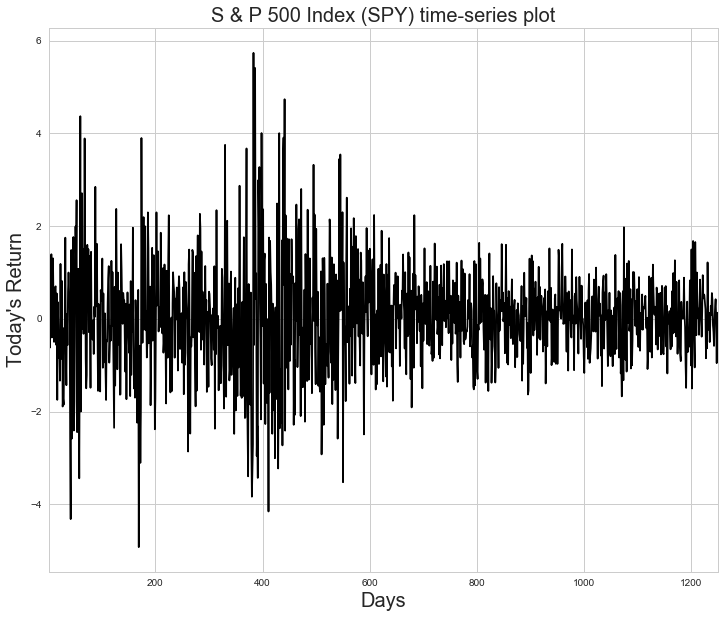

In [5]:
def plotTodayReturnTimeSeries():
    '''
    Exploration of the time-series of the 'Today' returns feature variable
    '''
    fig, ax = plt.subplots(figsize=(12,10))
    stock_market_data_table['Today'].plot(color='k')
    plt.title("S & P 500 Index (SPY) time-series plot", fontsize=20)
    plt.xlabel("Days", fontsize=20)
    plt.ylabel("Today's Return", fontsize=20)
    
plotTodayReturnTimeSeries()

#### Display the Descriptive Stats

In [6]:
def displayDataDescriptiveStats():
    '''
    Let us have a look at the descriptive statistics of the problem data
    '''
    print("S&P descriptive stats:\n{}\n".format(stock_market_data_table.describe())) 
    
displayDataDescriptiveStats()

S&P descriptive stats:
              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250.000000  1250.000000  1250.000000   
mean   2003.016000     0.003834     0.003919     0.001716     0.001636   
std       1.409018     1.136299     1.136280     1.138703     1.138774   
min    2001.000000    -4.922000    -4.922000    -4.922000    -4.922000   
25%    2002.000000    -0.639500    -0.639500    -0.640000    -0.640000   
50%    2003.000000     0.039000     0.039000     0.038500     0.038500   
75%    2004.000000     0.596750     0.596750     0.596750     0.596750   
max    2005.000000     5.733000     5.733000     5.733000     5.733000   

             Lag5       Volume        Today    Direction  
count  1250.00000  1250.000000  1250.000000  1250.000000  
mean      0.00561     1.478305     0.003138     0.518400  
std       1.14755     0.360357     1.136334     0.499861  
min      -4.92200     0.356070    -4.922000     0.000000  
25%      -0.640

#### Diplay Data Distributions

Histogram/distributions of all the data vectors:





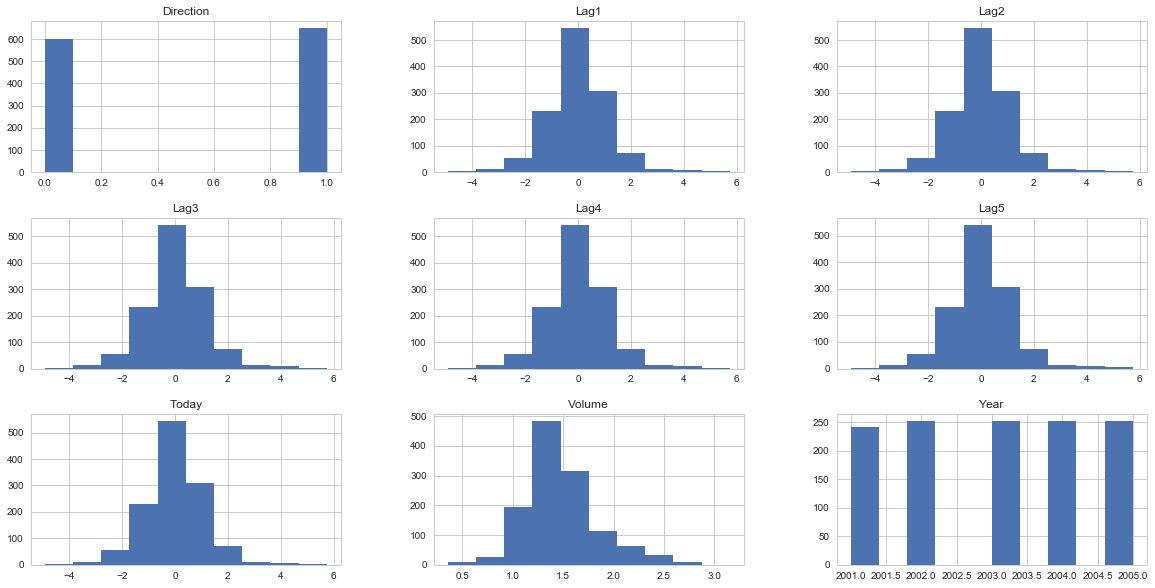

In [7]:
def plotDataDistributions():
    '''
    Plots the histogram/distributions of all the data vectors
    '''
    plt.rcParams["figure.figsize"] = (20,10)
    print("Histogram/distributions of all the data vectors:\n")
    ax = stock_market_data_table.hist()
    print("\n")

plotDataDistributions()

#### Dispaly Boxplots of some features

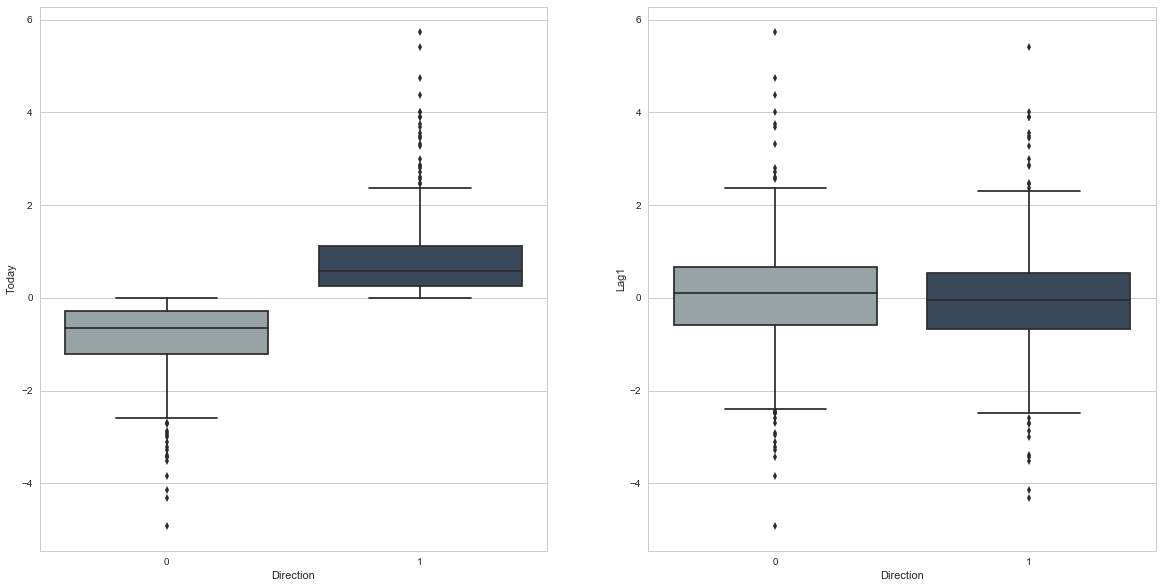

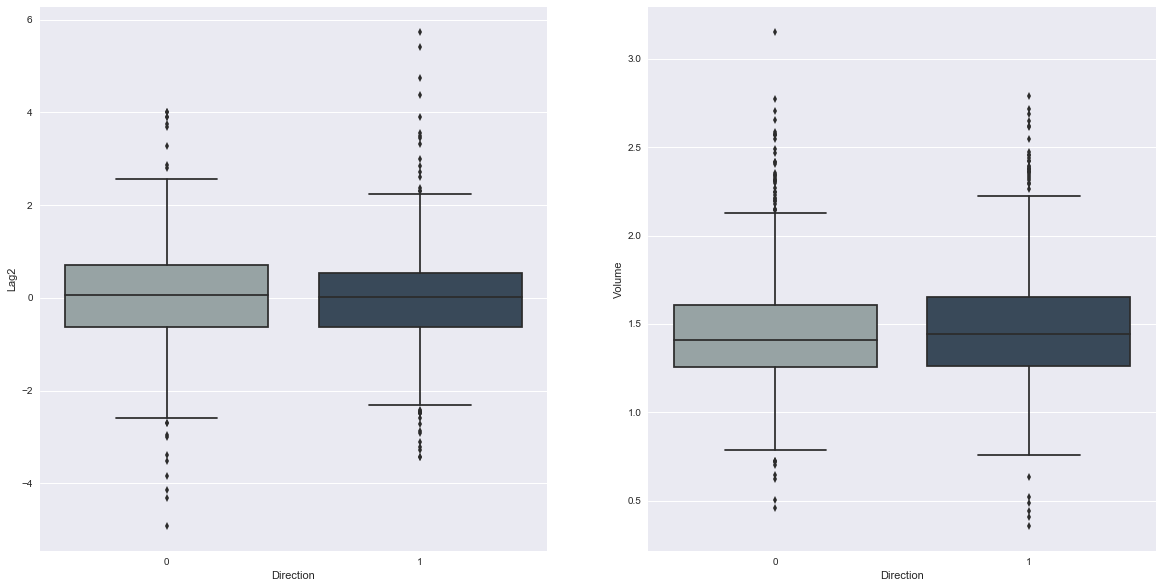

In [8]:
def plotBoxplotOfReturnVariables():
    def plotBoxplotOfReturnVariable(feature_names, output_name, data):
        '''
        Create a Boxplot for 2 features wrt Direction
        '''
        fig, axes =plt.subplots(1,2)
        sns.set_style("darkgrid")
        flatui = [  "#95a5a6",  "#34495e"]
        for i,t in enumerate(feature_names):
            sns.boxplot(  y=t, x= output_name, data=data,  orient='v',ax=axes[i % 2] ,  palette= flatui)
        
    feature_names1 = ['Today', 'Lag1']
    feature_names2 = ['Lag2', 'Volume']
    output_name = "Direction"
    plotBoxplotOfReturnVariable(feature_names1, output_name, stock_market_data_table)
    plotBoxplotOfReturnVariable(feature_names2, output_name, stock_market_data_table)

plotBoxplotOfReturnVariables()

#### Display Perason Heatmaps to depict correlation b/w features and output variables

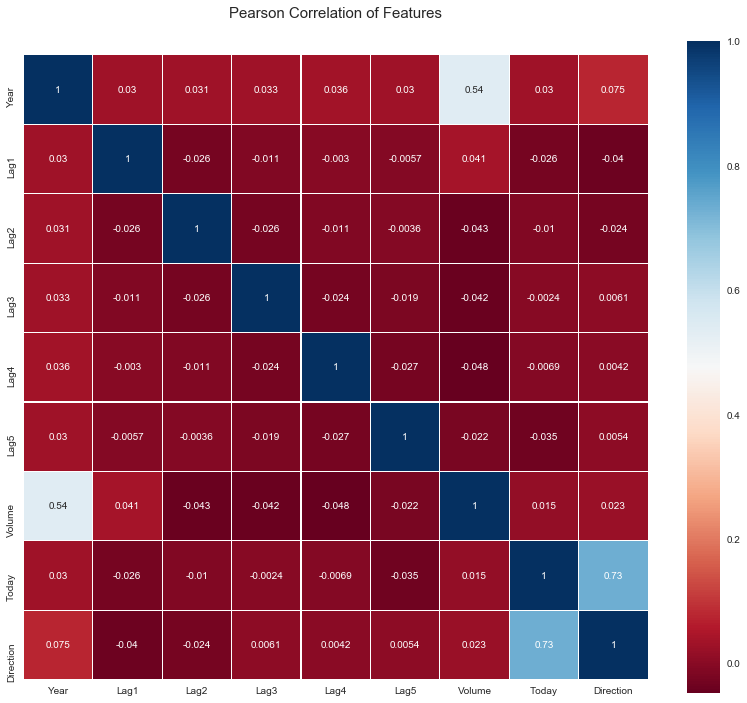

In [9]:
def plotPearsonHeatMap(data):
    '''
    Use Pearson Correlation metric to understand the relationship/correlation between the feature variables and the output
    '''
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
    
plotPearsonHeatMap(stock_market_data_table)

### Pre-process the data to improve the predictive power by following these steps: 
 - Identify data features/inputs (X) and responses/output (y) 
 - Rescale X data using Standardization, i.e ensure all of the vectors of X have a mean value of zero and a standard deviation of 1
 - Split the Data into Training and Valuation patitions

In [10]:
def identifyFeaturesAndResponses():
    '''
    Identify data features/inputs (X) and responses/output (y)
    '''
    n_cols = len(cols) - 1
    stock_market_data_table.columns = range(len(stock_market_data_table.columns))
    stock_market_data = stock_market_data_table.as_matrix()
    X = stock_market_data[:,0:n_cols]
    y = stock_market_data[:,n_cols]
    y = y.reshape(y.shape[0], 1)
    return X, y

def standardizeData(X):
    '''
    Rescale X feature data to have zero mean and unit variance
    '''
    scaler = StandardScaler()
    scaler.fit(X)
    X_scale = scaler.transform(X)
    return scaler, X_scale

def splitData(X, y, split_fraction=0.3, rand_seed = 10):
    '''
    Split the Data into Training and Valuation patitions
    '''
    X_train, X_val, y_train, y_val = smo.train_test_split(X, y, test_size=split_fraction, random_state=rand_seed)
    return (X_train, X_val, y_train, y_val)

def samplePreprocessedData(X_train, X_val, y_train, y_val):
    print("Sample of pre-processed X_train data:\n{}\n".format(X_train[:3,:]))
    print("Sample of pre-processed X_val data:\n{}\n".format(X_val[:3,:]))
    print("Sample of pre-processed y_train data:\n{}\n".format(y_train[:3,:]))
    print("Sample of pre-processed y_val data:\n{}\n".format(y_val[:3,:]))
    

def preprocessData():
    '''
     Pre-process the data to improve the predictive power of our model(s)
    '''
    X, y = identifyFeaturesAndResponses()
    #print("X.shape: {0}\ty.shape: {1}".format(X.shape, y.shape))
    scaler, X_scaled = standardizeData(X)
    X_train, X_val, y_train, y_val = splitData(X_scaled, y)
    samplePreprocessedData(X_train, X_val, y_train, y_val)

preprocessData()

Sample of pre-processed X_train data:
[[ 1.40863623 -0.67600326 -0.65231772  0.06350465  0.62229001  0.0779279
   1.25474401 -0.2387035 ]
 [ 1.40863623 -0.06588439  0.43235579  0.31740376  0.19358736  0.2191547
   0.6557927  -0.18323987]
 [-1.43135617  0.48700833 -0.09853555  0.20934289  0.91658383  1.39691643
  -0.96916291  0.33882257]]

Sample of pre-processed X_val data:
[[ 1.40863623  1.47393943  0.13037283 -1.32108013  1.31278239 -0.88101948
   1.99738812 -0.21141187]
 [ 0.69863813 -0.05708036  0.28180452  1.33212166 -0.01900699  0.36735565
  -0.16630442  0.58444723]
 [-0.01135997 -1.0572175  -0.72627273  0.88055023 -0.56367019  0.13982359
   0.28814902  0.47616109]]

Sample of pre-processed y_train data:
[[0.]
 [0.]
 [1.]]

Sample of pre-processed y_val data:
[[0.]
 [1.]
 [1.]]

